In [1]:
#setting system path
base_path = 'c:/Users/tpiechowiak/OneDrive - GN Store Nord/GNOS data/'

In [2]:
#loading some stuff 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import datetime


In [3]:
#now loading the different pickle files containing the ADL files for the different use-time categories
with open(base_path + "UseTime_resampled.pkl", "rb") as input_file:
    ADL_use_time = pickle.load(input_file)
print("Read ADL use-time from pickle file")

with open(base_path + 'hi_id_low_usage_subjects.pkl','rb') as input_file:
    hi_id_low_use = pickle.load(input_file)
print('Read hi ids low usage')


Read ADL use-time from pickle file
Read hi ids low usage


In [4]:
len(hi_id_low_use)

5820

In [5]:
#number of weeks between dates
def diff_time(start, end):
    x = pd.to_datetime(end) - pd.to_datetime(start)
    return int(x / np.timedelta64(1, 'W'))

In [6]:
#make subgroup for low-usage candidates
low_usage = ADL_use_time[ADL_use_time['ADLRawData_HearingInstrumentId'].isin(hi_id_low_use)]

In [7]:
#now try to cluster low usage group with KMeans for H1, H2 2019
#first need to create an array for KMeans input 
#we cluster first for all HI
use_time_low = []
cnt = 0

cut_off = diff_time('2019-01-01','2019-12-31')

for hi_id, group in low_usage.groupby('ADLRawData_HearingInstrumentId'):
    cnt = cnt + 1
    if (cnt%1000 == 0):
        print('HI = ',cnt)
    tmp = group['UseTimeWeekly'].loc['2019-01-01':'2019-12-31'].values[0:cut_off]
    if(tmp.shape[0] != cut_off):
        continue
    if (np.any(tmp < 0)):
        continue
        
    use_time_low.append(tmp)
        
use_time_low_array= np.array(use_time_low)

HI =  1000
HI =  2000
HI =  3000
HI =  4000
HI =  5000


In [11]:
low_usage.keys()

Index(['ADLRawData_HearingInstrumentId', 'UseTimeWeekly', 'InterTimeInterval'], dtype='object')

In [12]:
#import sklearn packages for clustering and pre-processing
from sklearn.cluster import KMeans

In [13]:
def seek_cluster_number(X, max_clust):
    SSE = []
    km = []
    cnt = 0
    for idx in range(1, max_clust):
        cnt = cnt + 1        
        print('Iteration = ',cnt)
        tmp = KMeans(n_clusters = idx, \
                    init = 'k-means++',\
                    n_init = 10,\
                    max_iter = 100,\
                    random_state = 0)
        tmp.fit(X)
        SSE.append(tmp.inertia_)
        km.append(tmp)
    plt.plot(range(1,max_clust), SSE, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()
    return km

Iteration =  1
Iteration =  2
Iteration =  3
Iteration =  4
Iteration =  5
Iteration =  6
Iteration =  7
Iteration =  8
Iteration =  9


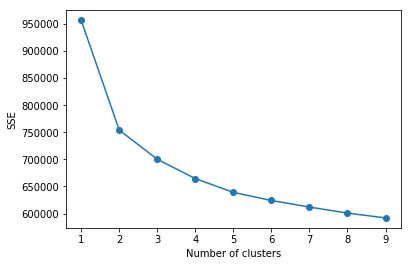

In [14]:
km = seek_cluster_number(use_time_low_array,10)

In [15]:
#we try 6 clusters
km[1].labels_


array([1, 0, 0, ..., 0, 0, 1])

C:\Users\tpiechowiak\AppData\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


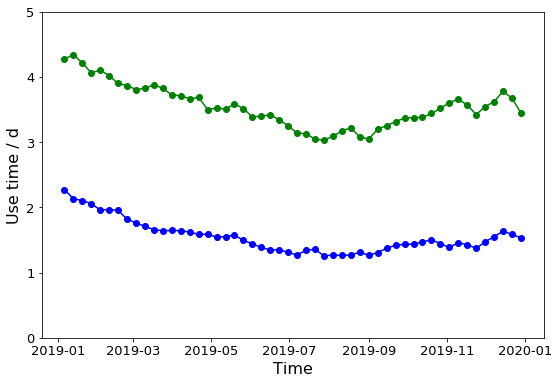

In [16]:
fig = plt.figure(figsize = (9,6))

a = pd.date_range(start= '2019-01-01',end = '2019-12-31', freq= '1W')

plt.plot(a,km[1].cluster_centers_[0],'bo-',\
         a,km[1].cluster_centers_[1],'go-')

axes = fig.gca()
axes.set_ylim([0, 5])
plt.xlabel('Time',fontsize = 16)
plt.ylabel('Use time / d', fontsize = 16)
axes.tick_params(labelsize = 13)


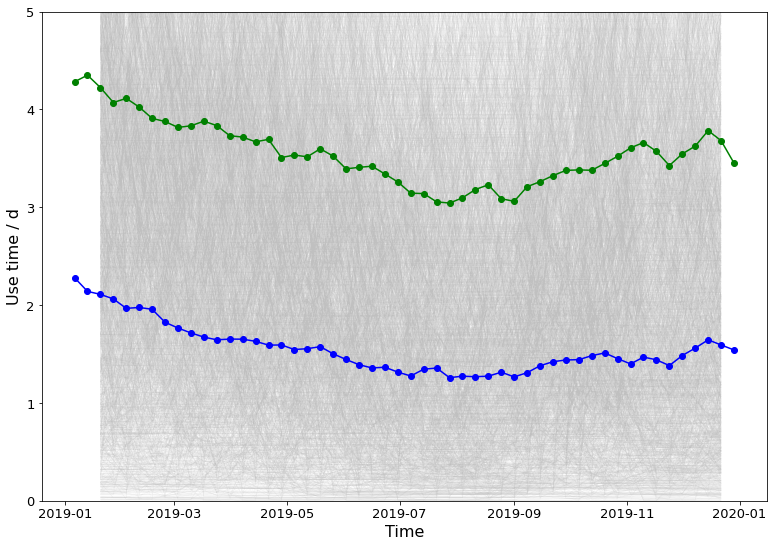

In [105]:
fig = plt.figure(figsize= (13,9))
#plot all use-time patterns in the same plot
N = 4
for idx in range(1,len(use_time_low)):
    tmp = np.convolve(use_time_low[idx], np.ones((N,))/N, mode='valid')
    plt.plot(a[N-2:-1],tmp,'silver',alpha = 0.7,linewidth=0.1, linestyle = 'dashed')
    
plt.plot(a,km[1].cluster_centers_[0],'bo-',\
         a,km[1].cluster_centers_[1],'go-')    
axes = fig.gca()
axes.set_ylim([0, 5])
plt.xlabel('Time',fontsize = 16)
plt.ylabel('Use time / d', fontsize = 16)
axes.tick_params(labelsize = 13)
plt.show()

In [17]:
#filter those with lowest use time cluster
cnt = 0
hi_cluster_0 = []
hi_cluster_1 = []

for idx in range(1,len(use_time_low_array)):
    if (idx%1000 == 0):
        print(idx)    
    if (km[1].labels_[idx] == 1):        
        hi_cluster_0.append(hi_id_low_use[idx])
    else:
        hi_cluster_1.append(hi_id_low_use[idx])


1000
2000
3000


In [19]:
cluster_0_data = low_usage[low_usage['ADLRawData_HearingInstrumentId'].isin(hi_cluster_0)]
cluster_1_data = low_usage[low_usage['ADLRawData_HearingInstrumentId'].isin(hi_cluster_1)]

In [21]:
cluster_0_data['UseTimeWeekly'].mean()

3.012953096907709

In [24]:
cluster_0_data['UseTimeWeekly']

ADLRawData_CreationTime
2017-10-15 00:00:00+00:00    2.015645
2017-10-22 00:00:00+00:00    2.015645
2017-10-29 00:00:00+00:00    4.337520
2017-11-05 00:00:00+00:00    4.337520
2017-11-12 00:00:00+00:00    2.892077
2017-11-19 00:00:00+00:00    2.808154
2017-11-26 00:00:00+00:00    4.487510
2017-12-03 00:00:00+00:00    4.487510
2017-12-10 00:00:00+00:00    1.472525
2017-12-17 00:00:00+00:00    4.942739
2017-12-24 00:00:00+00:00    1.128499
2017-12-31 00:00:00+00:00    2.857952
2018-01-07 00:00:00+00:00    1.618349
2018-01-14 00:00:00+00:00    2.956358
2018-01-21 00:00:00+00:00    1.415286
2018-01-28 00:00:00+00:00    1.415286
2018-02-04 00:00:00+00:00    0.799552
2018-02-11 00:00:00+00:00    0.481219
2018-02-18 00:00:00+00:00    0.481219
2018-02-25 00:00:00+00:00    2.176448
2018-03-04 00:00:00+00:00    0.082336
2018-03-11 00:00:00+00:00    0.082336
2018-03-18 00:00:00+00:00    1.085036
2018-03-25 00:00:00+00:00    1.085036
2018-04-01 00:00:00+00:00    1.085036
2018-04-08 00:00:00+00:00 

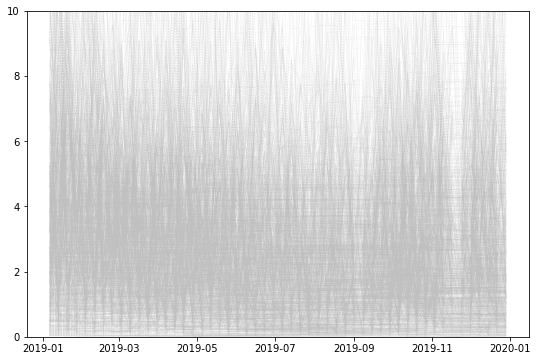

In [66]:
fig = plt.figure(figsize = (9,6))

for hi_id, group in cluster_0_data.groupby('ADLRawData_HearingInstrumentId'):
    tmp = group['UseTimeWeekly'].loc['2019-01-01':'2019-12-31'].values[0:cut_off]
    if(tmp.shape[0] != cut_off):
        continue
    if (np.any(tmp < 0)):
        continue
    
    plt.plot(a,tmp,'silver',alpha = 0.2,linewidth=0.5, linestyle = 'dashed')
    
axes = fig.gca()
axes.set_ylim([0, 5])

plt.show()


In [25]:
#saving list as pickle 
with open(base_path + 'hi_id_low_cluster.pkl', 'wb') as f:
   pickle.dump(hi_cluster_0, f)